# Assignment 2 Experiment 1

In this experiment, we aim to build the best possible model using Keras to classify images from the TinyImageNet dataset.

In [0]:
import os
import pickle
import scipy.misc
import numpy as np
from scipy.misc import imread
from skimage.transform import rescale, resize, downscale_local_mean
import keras
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
def plotAcc(history):  
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

# Upload data to Colab

In [0]:
from google.colab import files
uploaded = files.upload()

Saving tiny-imagenet-200.zip to tiny-imagenet-200.zip


In [0]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['tiny-imagenet-200.zip']), 'r')
data.extractall()

### About the dataset

Tiny Imagenet has 200 classes. Each class has 500 training images, 50 validation images, and 50 test images.

# Loading Data

In [0]:
def load_tiny_imagenet(path, wnids_path, resize='False', num_classes=200, dtype=np.float32):
  """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.
  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.
  Returns: A tuple of
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  """
  # First load wnids
  wnids_file = os.path.join(wnids_path, 'wnids' + '.txt')
  with open(os.path.join(path, wnids_file), 'r') as f:
    wnids = [x.strip() for x in f]

  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  words_file = os.path.join(wnids_path, 'words' + '.txt')
  with open(os.path.join(path, words_file), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
  class_names = [wnid_to_words[wnid] for wnid in wnids]

  # Next load training data.
  X_train = []
  y_train = []
  for i, wnid in enumerate(wnids):
    if (i + 1) % 20 == 0:
      print('loading training data for synset %d / %d' % (i + 1, len(wnids)))
    # To figure out the filenames we need to open the boxes file
    boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
      filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    if resize.lower() == 'true':
      X_train_block = np.zeros((num_images, 3, 32, 32), dtype=dtype)
    else:
      X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
    
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
      img_file = os.path.join(path, 'train', wnid, 'images', img_file)
      img = imread(img_file)
      
      if resize.lower() == 'true':
        img = scipy.misc.imresize(img, (32, 32, 3))
      if img.ndim == 2:
        ## grayscale file
        if resize.lower() == 'true':
          img.shape = (32, 32, 1)
        else:
          img.shape = (64, 64, 1)
      X_train_block[j] = img.transpose(2, 0, 1)
    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
  # We need to concatenate all training data
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  
  # Next load validation data
  with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
      # Select only validation images in chosen wnids set
      if line.split()[1] in wnids:
        img_file, wnid = line.split('\t')[:2]
        img_files.append(img_file)
        val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    
    if resize.lower() == 'true':
      X_val = np.zeros((num_val, 3, 32, 32), dtype=dtype)
    else:
      X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
 
    for i, img_file in enumerate(img_files):
      img_file = os.path.join(path, 'val', 'images', img_file)
      img = imread(img_file)
      if resize.lower() == 'true':
        img = scipy.misc.imresize(img, (32, 32, 3))
      if img.ndim == 2:
        if resize.lower() == 'true':
          img.shape = (32, 32, 1)
        else:
          img.shape = (64, 64, 1)

      X_val[i] = img.transpose(2, 0, 1)

  """
  # Next load test images
  # Students won't have test labels, so we need to iterate over files in the
  # images directory.
  img_files = os.listdir(os.path.join(path, 'test', 'images'))
  X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
  for i, img_file in enumerate(img_files):
    img_file = os.path.join(path, 'test', 'images', img_file)
    img = imread(img_file)
    if img.ndim == 2:
      img.shape = (64, 64, 1)
    X_test[i] = img.transpose(2, 0, 1)
  y_test = None
  y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
  if os.path.isfile(y_test_file):
    with open(y_test_file, 'r') as f:
      img_file_to_wnid = {}
      for line in f:
        line = line.split('\t')
        img_file_to_wnid[line[0]] = line[1]
    y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
    y_test = np.array(y_test)
  """
  
  # Omit x_test and y_test because they're unlabeled
  #return class_names, X_train, y_train, X_val, y_val, X_test, y_test
  print(X_train.shape)
  return class_names, X_train, y_train, X_val, y_val

### Split into Train/Validation sets & Resizing images to 32x32

In [0]:
class_names,X_train,y_train,X_val,y_val = load_tiny_imagenet('tiny-imagenet-200','',resize = 'true')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


loading training data for synset 20 / 200
loading training data for synset 40 / 200
loading training data for synset 60 / 200
loading training data for synset 80 / 200
loading training data for synset 100 / 200
loading training data for synset 120 / 200
loading training data for synset 140 / 200
loading training data for synset 160 / 200
loading training data for synset 180 / 200
loading training data for synset 200 / 200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(100000, 3, 32, 32)


### Preprocessing

In [0]:
num_classes = 200

#Format data to be the correct shape
X_train = np.einsum('iljk->ijkl', X_train)
X_val = np.einsum('iljk->ijkl', X_val)

# Convert labels to one hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
#X_train = X_train.astype('float32')
#X_val = X_val.astype('float32')
#X_train /= 255
#X_val /= 255

(100000, 32, 32, 3)
(100000, 200)
(10000, 32, 32, 3)


# Model #1 (From Assignment 1) 

This model obtained 0.8 accuracy on CIFAR-10 dataset

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



In [0]:
model.compile(loss='categorical_crossentropy', 
optimizer='adam', metrics=['accuracy'])

In [0]:
batch_size = 512
num_epochs = 100
if not data_augmentation:
  print('Not using data augmentation.')
		# Use the defined 'model_checkpoint' callback
  model.fit(X_train, y_train,
			  batch_size=batch_size,
			  epochs=num_epochs,
			  validation_data=(X_val, y_val),
			  shuffle=True, 
			  callbacks=[model_checkpoint])
else:
  print('Using real-time data augmentation.')
		# This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
			featurewise_center=False,  # set input mean to 0 over the dataset
			samplewise_center=False,  # set each sample mean to 0
			featurewise_std_normalization=False,  # divide inputs by std of the dataset
			samplewise_std_normalization=False,  # divide each input by its std
			zca_whitening=False,  # apply ZCA whitening
			rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
			width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
			height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
			horizontal_flip=True,  # randomly flip images
			vertical_flip=False)  # randomly flip images

		# Compute quantities required for feature-wise normalization
		# (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(X_train)

		# Fit the model on the batches generated by datagen.flow().
		# Use the defined 'model_checkpoint' callback
  history1 = model.fit_generator(datagen.flow(X_train, y_train,
						batch_size=batch_size),
						steps_per_epoch=X_train.shape[0] // batch_size,
						epochs=num_epochs,
						validation_data=(X_val, y_val))


Using real-time data augmentation.
Epoch 1/100
195/195 [==============================] - 51s 263ms/step - loss: 5.6343 - acc: 0.0091 - val_loss: 5.0705 - val_acc: 0.0219
Epoch 2/100
195/195 [==============================] - 49s 252ms/step - loss: 4.9174 - acc: 0.0344 - val_loss: 4.6728 - val_acc: 0.0645
Epoch 3/100
195/195 [==============================] - 49s 251ms/step - loss: 4.6647 - acc: 0.0585 - val_loss: 4.5053 - val_acc: 0.0811
Epoch 4/100
195/195 [==============================] - 49s 251ms/step - loss: 4.5035 - acc: 0.0773 - val_loss: 4.3533 - val_acc: 0.0960
Epoch 5/100
195/195 [==============================] - 49s 252ms/step - loss: 4.3775 - acc: 0.0937 - val_loss: 4.2424 - val_acc: 0.1096
Epoch 6/100
195/195 [==============================] - 49s 251ms/step - loss: 4.2734 - acc: 0.1082 - val_loss: 4.1319 - val_acc: 0.1306
Epoch 7/100
195/195 [==============================] - 49s 252ms/step - loss: 4.1826 - acc: 0.1199 - val_loss: 3.9676 - val_acc: 0.1508
Epoch 8/100
1

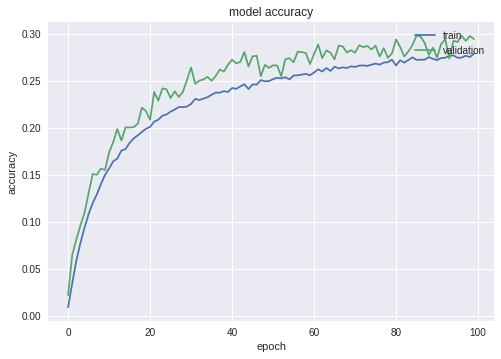

In [0]:
plotAcc(history1)

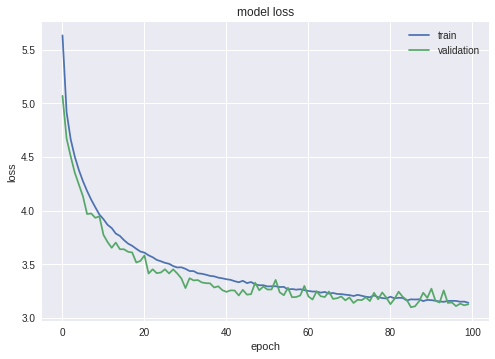

In [0]:
plotLosses(history1)

# Model #2 (CNN with Batch Normalization)

What is batch normalization?

Batch Normalization is used to solve the problem of internal covariate shift.

**Internal covariate shift** is when each hidden layer's distribution changes when there is a parameter update in the previous layer.


In [0]:
model  = Sequential()		
"""Block 1"""
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', 
input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Activation('relu'))
			
"""Block 2"""
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

"""Block 3"""
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

"""Block 4"""
model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
						
"""Block 5"""
model.add(Flatten())
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
			
"""Block Test"""
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))

"""Output Layer"""
model.add(Dense(num_classes))
model.add(Activation('softmax'))

"""Optimizer"""
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [0]:
batch_size = 512
num_epochs = 50
if not data_augmentation:
  print('Not using data augmentation.')
		# Use the defined 'model_checkpoint' callback
  model.fit(X_train, y_train,
			  batch_size=batch_size,
			  epochs=num_epochs,
			  validation_data=(X_val, y_val),
			  shuffle=True, 
			  callbacks=[model_checkpoint])
else:
  print('Using real-time data augmentation.')
		# This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
			featurewise_center=False,  # set input mean to 0 over the dataset
			samplewise_center=False,  # set each sample mean to 0
			featurewise_std_normalization=False,  # divide inputs by std of the dataset
			samplewise_std_normalization=False,  # divide each input by its std
			zca_whitening=False,  # apply ZCA whitening
			rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
			width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
			height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
			horizontal_flip=True,  # randomly flip images
			vertical_flip=False)  # randomly flip images

		# Compute quantities required for feature-wise normalization
		# (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(X_train)

		# Fit the model on the batches generated by datagen.flow().
		# Use the defined 'model_checkpoint' callback
  history2 = model.fit_generator(datagen.flow(X_train, y_train,
						batch_size=batch_size),
						steps_per_epoch=X_train.shape[0] // batch_size,
						epochs=num_epochs,
						validation_data=(X_val, y_val))


Using real-time data augmentation.
Epoch 1/50
195/195 [==============================] - 88s 451ms/step - loss: 4.9348 - acc: 0.0533 - val_loss: 4.7105 - val_acc: 0.0704
Epoch 2/50
195/195 [==============================] - 83s 427ms/step - loss: 4.3790 - acc: 0.1106 - val_loss: 4.3096 - val_acc: 0.1128
Epoch 3/50
195/195 [==============================] - 83s 428ms/step - loss: 4.1128 - acc: 0.1446 - val_loss: 4.1453 - val_acc: 0.1301
Epoch 4/50
195/195 [==============================] - 83s 428ms/step - loss: 3.9204 - acc: 0.1696 - val_loss: 4.0355 - val_acc: 0.1491
Epoch 5/50
195/195 [==============================] - 83s 427ms/step - loss: 3.7734 - acc: 0.1917 - val_loss: 3.9557 - val_acc: 0.1577
Epoch 6/50
195/195 [==============================] - 83s 428ms/step - loss: 3.6576 - acc: 0.2103 - val_loss: 3.8648 - val_acc: 0.1709
Epoch 7/50
195/195 [==============================] - 83s 428ms/step - loss: 3.5526 - acc: 0.2249 - val_loss: 3.7391 - val_acc: 0.1881
Epoch 8/50
195/195 [

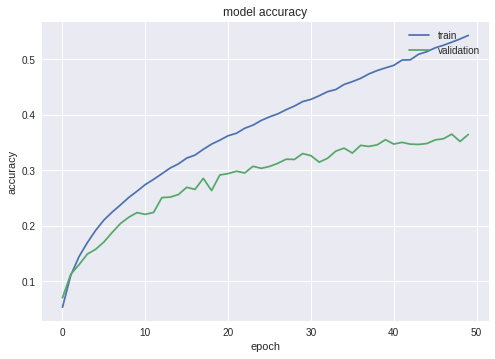

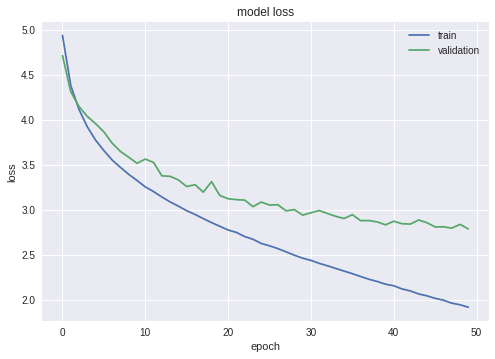

In [0]:
plotAcc(history2)
plotLosses(history2)

# Model #3 (After image augmentation)

*   **ZCA Whitening** 

Whitening is when we reduce the redundancy of a matrix of pixels. 
Less redundancy is useful for highlighting features and structures of the image to the learning model.
Unlike PCA, in ZCA the number of dimensions remain the same hence preserving the image.
*   **Randomly roated images at 90 degrees**

Hande roation of images by artifically adding rotated versions of images in the dataset.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

adam = keras.optimizers.Adam(lr=0.01,epsilon=1e-8)

model.compile(loss='categorical_crossentropy', 
optimizer=adam, metrics=['accuracy'])


In [0]:
batch_size = 1024
num_epochs = 10
data_augmentation = True
if not data_augmentation:
  print('Not using data augmentation.')
		# Use the defined 'model_checkpoint' callback
  model.fit(X_train, y_train,
			  batch_size=batch_size,
			  epochs=num_epochs,
			  validation_data=(X_val, y_val),
			  shuffle=True, 
			  callbacks=[model_checkpoint])
else:
  print('Using real-time data augmentation.')
		# This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
			samplewise_center=False,  # set each sample mean to 0
			samplewise_std_normalization=False,  # divide each input by its std
			zca_whitening=True,  # apply ZCA whitening
			rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
			width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
			height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
			horizontal_flip=False,  # randomly flip images
			vertical_flip=False)  # randomly flip images

		# Compute quantities required for feature-wise normalization
		# (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(X_train)

		# Fit the model on the batches generated by datagen.flow().
		# Use the defined 'model_checkpoint' callback
  history3 = model.fit_generator(datagen.flow(X_train, y_train,
						batch_size=batch_size),
						steps_per_epoch=X_train.shape[0] // batch_size,
						epochs=num_epochs,
						validation_data=(X_val, y_val))


Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:334: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
97/97 [==============================] - 946s 10s/step - loss: 5.2471 - acc: 0.0082 - val_loss: 5.4287 - val_acc: 0.0063
Epoch 2/10
97/97 [==============================] - 944s 10s/step - loss: 5.1532 - acc: 0.0125 - val_loss: 5.4855 - val_acc: 0.0054
Epoch 3/10
97/97 [==============================] - 952s 10s/step - loss: 5.1091 - acc: 0.0164 - val_loss: 5.8056 - val_acc: 0.0079
Epoch 4/10
97/97 [==============================] - 958s 10s/step - loss: 5.0642 - acc: 0.0193 - val_loss: 5.9799 - val_acc: 0.0072
Epoch 5/10
97/97 [==============================] - 944s 10s/step - loss: 5.0153 - acc: 0.0232 - val_loss: 6.4767 - val_acc: 0.0077
Epoch 6/10
97/97 [==============================] - 844s 9s/step - loss: 4.9871 - acc: 0.0259 - val_loss: 7.1397 - val_acc: 0.0109
Epoch 7/10
97/97 [==============================] - 973s 10s/step - loss: 4.9663 - acc: 0.0275 - val_loss: 7.5152 - val_acc: 0.0125
Epoch 8/10
97/97 [==============================] - 942s 10s/step - loss: 4.9

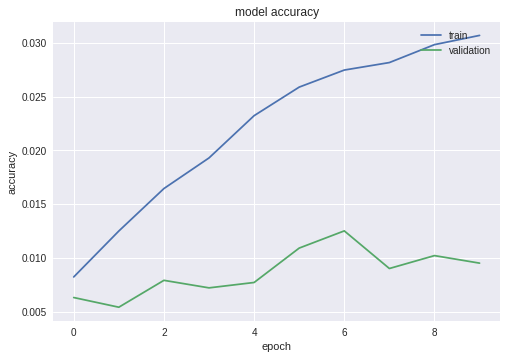

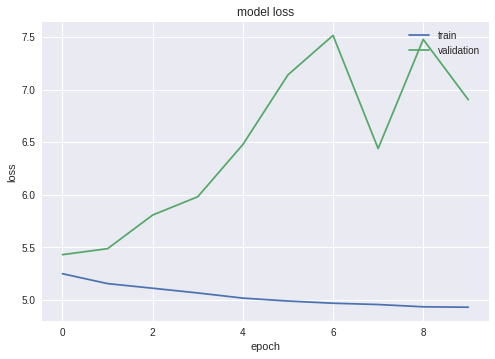

In [0]:
plotAcc(history3)
plotLosses(history3)

# Model #4 (Adding a block & increasing dropout)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', 
optimizer='adadelta', metrics=['accuracy'])


In [0]:
data_augmentation = True
batch_size = 1024

num_epochs = 100
if not data_augmentation:
  print('Not using data augmentation.')
		# Use the defined 'model_checkpoint' callback
  model.fit(X_train, y_train,
			  batch_size=batch_size,
			  epochs=num_epochs,
			  validation_data=(X_val, y_val),
			  shuffle=True, 
			  callbacks=[model_checkpoint])
else:
  print('Using real-time data augmentation.')
		# This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
			featurewise_center=False,  # set input mean to 0 over the dataset
			samplewise_center=False,  # set each sample mean to 0
			featurewise_std_normalization=False,  # divide inputs by std of the dataset
			samplewise_std_normalization=False,  # divide each input by its std
			zca_whitening=False,  # apply ZCA whitening
			rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
			width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
			height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
			horizontal_flip=True,  # randomly flip images
			vertical_flip=False)  # randomly flip images

		# Compute quantities required for feature-wise normalization
		# (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(X_train)

		# Fit the model on the batches generated by datagen.flow().
		# Use the defined 'model_checkpoint' callback
  history4 = model.fit_generator(datagen.flow(X_train, y_train,
						batch_size=batch_size),
						steps_per_epoch=X_train.shape[0] // batch_size,
						epochs=num_epochs,
						validation_data=(X_val, y_val))


Using real-time data augmentation.
Epoch 1/100
97/97 [==============================] - 48s 490ms/step - loss: 6.4915 - acc: 0.0052 - val_loss: 5.2976 - val_acc: 0.0078
Epoch 2/100
97/97 [==============================] - 47s 481ms/step - loss: 5.2876 - acc: 0.0079 - val_loss: 5.2875 - val_acc: 0.0106
Epoch 3/100
97/97 [==============================] - 47s 480ms/step - loss: 5.2361 - acc: 0.0105 - val_loss: 5.2112 - val_acc: 0.0157
Epoch 4/100
97/97 [==============================] - 47s 480ms/step - loss: 5.1800 - acc: 0.0131 - val_loss: 5.1902 - val_acc: 0.0163
Epoch 5/100
97/97 [==============================] - 47s 480ms/step - loss: 5.1441 - acc: 0.0143 - val_loss: 5.1602 - val_acc: 0.0188
Epoch 6/100
97/97 [==============================] - 47s 480ms/step - loss: 5.1058 - acc: 0.0177 - val_loss: 5.1226 - val_acc: 0.0241
Epoch 7/100
97/97 [==============================] - 47s 482ms/step - loss: 5.0571 - acc: 0.0213 - val_loss: 5.0843 - val_acc: 0.0243
Epoch 8/100
97/97 [========

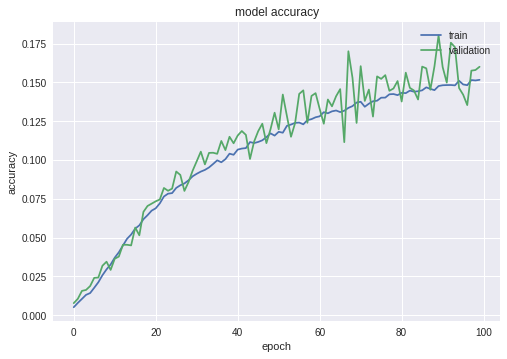

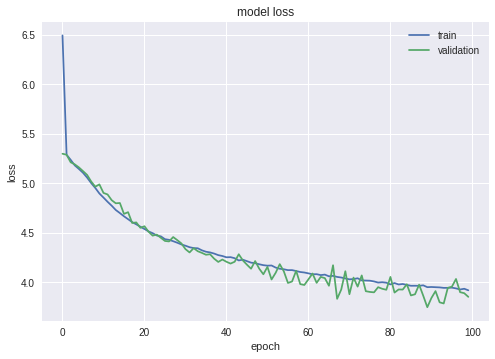

In [0]:
plotAcc(history4)
plotLosses(history4)

## Results

In [0]:
acc_arr = {'model 1':0.2977,'model 2':0.3647,'model 3':0.0095,'model 4':0.1601}

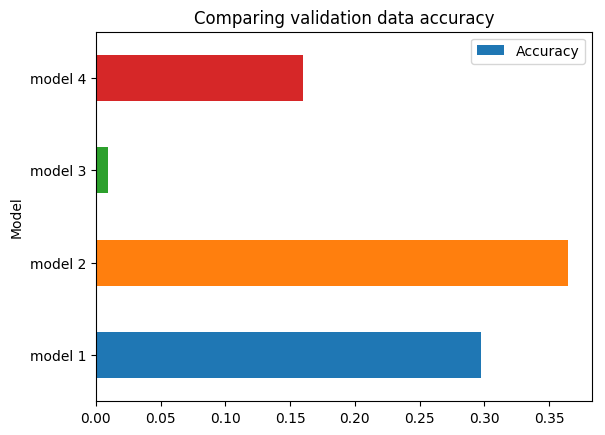

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(list(acc_arr.items()), columns=['Model', 'Accuracy'])
ax = df.plot.barh(x='Model', y='Accuracy',title = "Comparing validation data accuracy",legend = 'false')